In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.python.keras import backend as K
import numpy as np
import matplotlib as mpl
from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

sess = K.get_session()

In [12]:
#We are using the image of Deepika Padukone
url = 'http://3.bp.blogspot.com/-xu1DdNaVqCU/VqakGBws_8I/AAAAAAAAWNo/egrg2nNfAA0/s1600/deepika-padukone-3.jpg'
# Download an image and read it into a NumPy array.
def download(url, target_size=None):
    #name = url.split('/')[-1]
    #image_path = tf.keras.utils.get_file(name, origin=url)
    image_path = 'spagetti-dinner.png'
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    return img

In [13]:
# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)


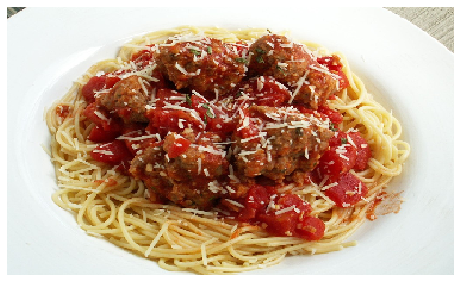

In [14]:
# Display an image
def show(img):
    plt.figure(figsize=(8,8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
# Downsizing the image makes it easier to work with.
original_img = download(url, target_size=[225, 375])
original_img = np.array(original_img)
show(original_img)

In [15]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [16]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [17]:
@tf.function
def deepdream(model, img, step_size):
    with tf.GradientTape() as tape:
        # This needs gradients relative to `img`
        # `GradientTape` only watches `tf.Variable`s by default
        tape.watch(img)
        loss = calc_loss(img, model)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    
    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)
    return loss, img

In [18]:
def run_deep_dream_simple(model, img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    for step in range(steps):
        loss, img = deepdream(model, img, step_size)

    if step % 100 == 0:
        clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    clear_output(wait=True)
    
    with sess.as_default():
        array=img.eval()
    
    show(array)

    return result



In [19]:
#dream_img = run_deep_dream_simple(model=dream_model, img=original_img, 
#                                  steps=steps_def, step_size=steps_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


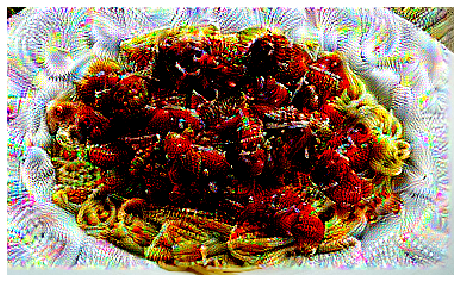

In [ ]:
OCTAVE_SCALE = 1.3
steps_def = 2000
steps_size = 0.001

img = tf.constant(np.array(original_img))
base_shape = tf.cast(tf.shape(img)[:-1], tf.float32)

for n in range(3):
    new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape)
    
    with sess.as_default():
        array=img.eval()
  
    img = run_deep_dream_simple(model=dream_model, img=array, steps=steps_def, step_size=steps_size)

In [ ]:
clear_output(wait=True)
#sess = K.get_session()
#array = sess.run(img)
#print(type(array))
with sess.as_default():
    array=img.eval()
    print(type(array))

show(array)